In [23]:
import pandas as pd
import numpy as np
import json
import os

In [24]:
from IPython.display import display, HTML

# For pandas dataframes - show all rows and columns
'''
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
'''

# For numpy arrays - show all elements
np.set_printoptions(threshold=np.inf)

# For pretty display of large HTML content
HTML("<style>.jp-OutputArea-output { max-height: none; }</style>")

In [25]:
folder_path = "./humaneval/python-small-test/"
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

all_entries = []

for file in json_files:
    file_path = os.path.join(folder_path, file)
    with open(file_path, "r") as f:
        content = json.load(f)
    for entry in content.get("data", []):
        entry["source_file"] = file
        all_entries.append(entry)

df = pd.DataFrame(all_entries)

# Step 2: Flatten `code_gpt_score` subfields
score_df = pd.json_normalize(df["code_gpt_score"])

# Step 3: Merge back to the original dataframe
df = df.drop(columns=["code_gpt_score"]).join(score_df)

# Optional: rename columns if needed
df = df.rename(columns={
    "code_gpt_score": "gpt_score",
    "comparison": "gpt_comparison",
    "parsed_comparison": "gpt_parsed_comparison"
})


df.head(2)


,pass,question,program,canonical_solution,question_id,source_file,gpt_score,gpt_comparison,gpt_parsed_comparison
0,True,"Task We are given two strings s and c, you hav...","def reverse_delete(s,c):\n\n # your code he...","def reverse_delete(s,c):\n s = ''.join([cha...",112,Qwen-2-0-4-0.4-sample-0.json,0.0,1. The problem statement requires a function t...,Yes
1,True,You're given a list of deposit and withdrawal ...,from typing import List\n\n\ndef below_zero(op...,from typing import List\n\n\ndef below_zero(op...,3,Qwen-2-0-4-0.4-sample-0.json,1.0,Let's evaluate the code snippet step by step t...,Yes


In [26]:
import re

def parse_filename(filename):
    """
    Parse a filename in the format 'Qwen-2-0-4-0.4-sample-0.json' to extract components.
    
    Args:
        filename (str): The filename to parse
        
    Returns:
        dict: Dictionary containing extracted components or None if pattern doesn't match
    """
    # Regular expression to match the pattern: Qwen-<step>-<analyze_prompt_index>-<compare_prompt_index>-<temperature>-sample-<number>.json
    pattern = r'Qwen-(\d+)-(\d+)-(\d+)-(\d+\.\d+)-sample-\d+\.json'
    
    match = re.match(pattern, filename)
    if match:
        return {
            'source_file': filename,
            'step': int(match.group(1)),
            'analyze_prompt_index': int(match.group(2)),
            'compare_prompt_index': int(match.group(3)),
            'temperature': float(match.group(4))
        }
    return None

def create_dataframe_from_filenames(file_list):
    """
    Create a DataFrame from a list of filenames by parsing each filename.
    
    Args:
        file_list (list): List of filenames to parse
        
    Returns:
        pandas.DataFrame: DataFrame containing the parsed information
    """
    results = []
    
    for filename in file_list:
        parsed_data = parse_filename(filename)
        if parsed_data:
            results.append(parsed_data)
    
    if not results:
        return pd.DataFrame(columns=['filename', 'step', 'analyze_prompt_index', 
                                    'compare_prompt_index', 'temperature'])
    
    return pd.DataFrame(results)

def process_directory(directory_path):
    """
    Process all matching files in a directory and return a DataFrame.
    
    Args:
        directory_path (str): Path to the directory containing the files
        
    Returns:
        pandas.DataFrame: DataFrame containing the parsed information
    """
    filenames = [f for f in os.listdir(directory_path) 
                if f.startswith('Qwen-') and f.endswith('.json')]
    return create_dataframe_from_filenames(filenames)

In [27]:
parsed_df = process_directory("./humaneval/python-small-test/")
df = pd.merge(
        df, 
        parsed_df, 
        on='source_file',
        how='inner'  # Only keep rows that match in both dataframes
    )
original = df.copy()
df = df[(df['gpt_parsed_comparison'] == 'Yes') | (df['gpt_parsed_comparison'] == 'No')]
#df = df[df['temperature'] == 0.4]
df.head(2)

,pass,question,program,canonical_solution,question_id,source_file,gpt_score,gpt_comparison,gpt_parsed_comparison,step,analyze_prompt_index,compare_prompt_index,temperature
0,True,"Task We are given two strings s and c, you hav...","def reverse_delete(s,c):\n\n # your code he...","def reverse_delete(s,c):\n s = ''.join([cha...",112,Qwen-2-0-4-0.4-sample-0.json,0.0,1. The problem statement requires a function t...,Yes,2,0,4,0.4
1,True,You're given a list of deposit and withdrawal ...,from typing import List\n\n\ndef below_zero(op...,from typing import List\n\n\ndef below_zero(op...,3,Qwen-2-0-4-0.4-sample-0.json,1.0,Let's evaluate the code snippet step by step t...,Yes,2,0,4,0.4


Metrics for each parameter combination:


,analyze_prompt_index,compare_prompt_index,temperature,accuracy,f1_score
0,0,0,0.4,0.870370,0.867925
6,0,8,0.4,0.870229,0.870229
8,1,0,0.4,0.863636,0.863636
3,0,2,0.9,0.862595,0.857143
2,0,2,0.4,0.862595,0.857143
4,0,4,0.4,0.861538,0.857143
12,1,4,0.4,0.856061,0.857143
5,0,4,0.9,0.856061,0.859259
14,1,8,0.4,0.856061,0.857143
10,1,2,0.4,0.854962,0.845528



Overall Metrics:
Accuracy: 0.8503
F1 Score: 0.8488


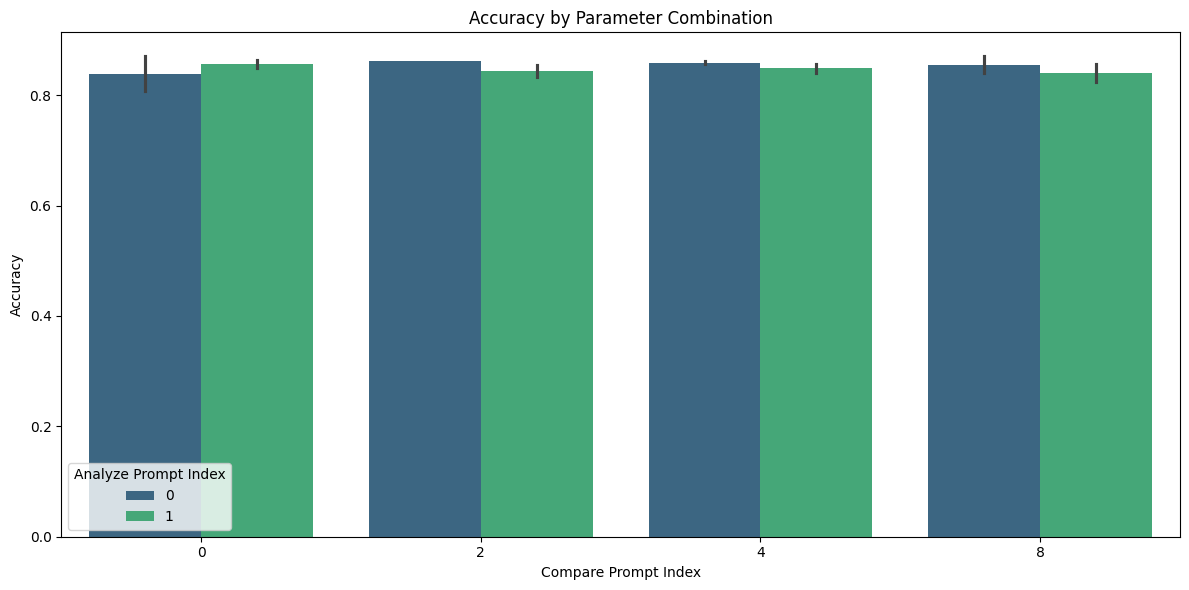

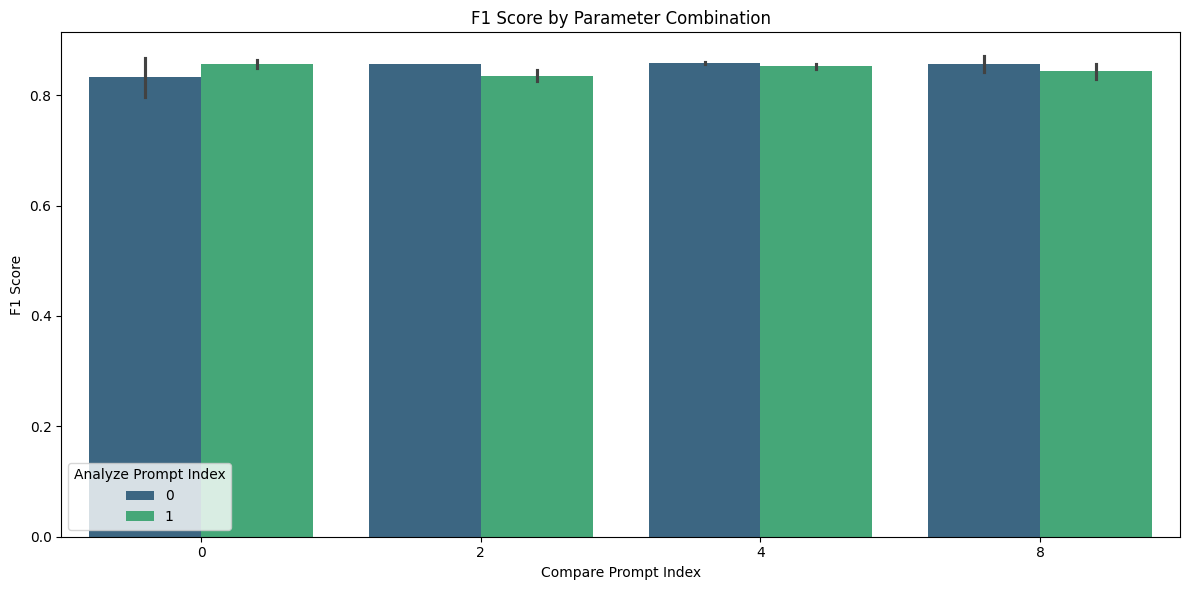

In [28]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert string 'Yes'/'No' to boolean True/False to match with 'pass'
df['predicted_bool'] = df['gpt_parsed_comparison'].apply(lambda x: True if x == 'Yes' else False)

# Group by the parameters we're interested in
grouped = df.groupby(['analyze_prompt_index', 'compare_prompt_index', 'temperature'])

# Create a dataframe to store the results
results = []

# Calculate metrics for each group
for name, group in grouped:
    analyze_idx, compare_idx, temp = name
    group_accuracy = accuracy_score(group['pass'], group['predicted_bool'])
    group_f1 = f1_score(group['pass'], group['predicted_bool'])
    group_conf_matrix = confusion_matrix(group['pass'], group['predicted_bool'])
    
    # Store the results
    results.append({
        'analyze_prompt_index': analyze_idx,
        'compare_prompt_index': compare_idx,
        'temperature': temp,
        'accuracy': group_accuracy,
        'f1_score': group_f1,
        'sample_size': len(group),
        'TN': group_conf_matrix[0, 0] if group_conf_matrix.shape == (2, 2) else 0,
        'FP': group_conf_matrix[0, 1] if group_conf_matrix.shape == (2, 2) else 0,
        'FN': group_conf_matrix[1, 0] if group_conf_matrix.shape == (2, 2) else 0,
        'TP': group_conf_matrix[1, 1] if group_conf_matrix.shape == (2, 2) else 0
    })

# Convert to DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Sort by accuracy (descending)
results_df = results_df.sort_values('accuracy', ascending=False)

# Display the results
print("Metrics for each parameter combination:")
display(results_df[['analyze_prompt_index', 'compare_prompt_index', 'temperature', 'accuracy', 'f1_score']])

# Calculate overall metrics for comparison
overall_accuracy = accuracy_score(df['pass'], df['predicted_bool'])
overall_f1 = f1_score(df['pass'], df['predicted_bool'])
print(f"\nOverall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"F1 Score: {overall_f1:.4f}")

# Visualize accuracy by parameter combination
plt.figure(figsize=(12, 6))
sns.barplot(x='compare_prompt_index', y='accuracy', hue='analyze_prompt_index',
            palette='viridis', data=results_df)
plt.title('Accuracy by Parameter Combination')
plt.xlabel('Compare Prompt Index')
plt.ylabel('Accuracy')
plt.legend(title='Analyze Prompt Index')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Visualize F1 score by parameter combination
plt.figure(figsize=(12, 6))
sns.barplot(x='compare_prompt_index', y='f1_score', hue='analyze_prompt_index',
            palette='viridis', data=results_df)
plt.title('F1 Score by Parameter Combination')
plt.xlabel('Compare Prompt Index')
plt.ylabel('F1 Score')
plt.legend(title='Analyze Prompt Index')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [29]:
# Get the false negatives (actual pass = True, predicted = False)
false_negatives = df[(df['pass'] == True) & (df['predicted_bool'] == False)]
print(f"Total False Negatives: {len(false_negatives)}")

# Get the false positives (actual pass = False, predicted = True)
false_positives = df[(df['pass'] == False) & (df['predicted_bool'] == True)]
print(f"Total False Positives: {len(false_positives)}")

def sort_df(table):
    # Count occurrences of each question_id
    count = table['question_id'].value_counts()
    
    # Sort the table by frequency of question_id
    sorted_table = table.sort_values(by='question_id', key=lambda x: count[x], ascending=False)
    return sorted_table


false_negatives = sort_df(false_negatives)
false_positives = sort_df(false_positives)

Total False Negatives: 115
Total False Positives: 196


In [30]:
num = -1

In [31]:
from IPython.display import display, HTML
import textwrap

# Set CSS to force wrapping and prevent any omission
display(HTML("""
<style>
    div.output_area pre {
        white-space: pre-wrap;       /* Preserve spacing but wrap */
        word-break: break-word;      /* Break long words if needed */
        overflow-wrap: anywhere;     /* Emergency break for very long strings */
    }
    div.output_area {
        max-width: 100%;            /* Prevent horizontal expansion */
        overflow-x: hidden !important;  /* Hide horizontal scroll */
    }
</style>
"""))



num += 1
test_df = false_negatives
# Get the data (more efficient query)
#record = test_df[test_df['question_id'] == idx]
record = test_df.iloc[num]  # Assuming you want the first record for demonstration

# Display each part with guaranteed wrapping
def safe_display(title, content):
    display(HTML(f"<strong>{title}:</strong>"))
    display(HTML(f"<pre>{textwrap.dedent(str(content))}</pre>"))  # str() ensures no omission
    display(HTML("<hr style='margin: 10px 0;'>"))


safe_display('Question', record['question'])
safe_display("Program", record['program'])
safe_display("Canonical Solution", record['canonical_solution'])
safe_display("GPT Comparison", record['gpt_comparison'])
safe_display('with/without analysis', record['analyze_prompt_index'])

display(HTML(f"<div>Case ID: {record['question_id']}, Index: {num}</div>"))


In [32]:
# Create a copy of the original dataframe
new_df = original.copy()

# Add a new column that categorizes gpt_parsed_comparison values
def categorize_parsed_comparison(value):
    if value == 'Yes' or value == 'No':
        return True
    else:
        return False

# Apply the function to create a column indicating if the comparison was parsed
new_df['parsed_category'] = new_df['gpt_parsed_comparison'].apply(categorize_parsed_comparison)

# Group by prompt indices and temperature, then calculate the percentage of parsed responses
grouped = new_df.groupby(['analyze_prompt_index', 'compare_prompt_index', 'temperature']).agg(
    parsed_percentage=('parsed_category', 'mean'),
    sample_size=('parsed_category', 'count')
)

# Sort by parsed_percentage in descending order
grouped = grouped.sort_values('parsed_percentage', ascending=False)

# Display the results
grouped

parsed_percentage  \
analyze_prompt_index compare_prompt_index temperature                      
0                    4                    0.9                   1.000000   
1                    2                    0.9                   1.000000   
                     4                    0.9                   1.000000   
                     8                    0.4                   1.000000   
                     4                    0.4                   1.000000   
                     0                    0.4                   1.000000   
                                          0.9                   1.000000   
0                    2                    0.9                   0.992424   
                                          0.4                   0.992424   
                     8                    0.4                   0.992424   
1                    2                    0.4                   0.992424   
0                    8                    0.9                   0.992424   
1                    8                    0.9                   0.992424   
0                    0                    0.9                   0.984848   
                     4                    0.4                   0.984848   
                     0                    0.4                   0.818182   

                                                       sample_size  
analyze_prompt_index compare_prompt_index temperature               
0                    4                    0.9                  132  
1                    2                    0.9                  132  
                     4                    0.9                  132  
                     8                    0.4                  132  
                     4                    0.4                  132  
                     0                    0.4                  132  
                                          0.9                  132  
0                    2                    0.9                  132  
                                          0.4                  132  
                     8                    0.4                  132  
1                    2                    0.4                  132  
0                    8                    0.9                  132  
1                    8                    0.9                  132  
0                    0                    0.9                  132  
                     4                    0.4                  132  
                     0                    0.4                  132